In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#%matplotlib inline

In [ ]:
data=pd.read_csv("properties_2016.csv")

In [2]:
def make_date_int(df,col,date_ref,):
    from datetime import datetime
    import numpy as np
    date_format = "%Y-%m-%d"
    a = datetime.strptime(date_ref, date_format)
    df[col]=pd.to_datetime(df[col],format="%Y-%m-%d")
    df['start']=a
    df.timestamp=pd.to_datetime(df[col],format="%Y-%m-%d")
    df['end']=(df[col]-df['start'])
    df[col]=(df.end.values/np.timedelta64(1, 'D')).astype(int)
    df.drop(['start','end'],axis=1,inplace=True)

def find_nearby(df,column,dist,method,text=False):
    print(column)
    for i in df.loc[df[column].isnull(),column].index:   
        win=dist
        lat=df.loc[i,'latitude']
        long=df.loc[i,'longitude']
        val=np.nan
        not_found=True
        while (not_found or np.isnan(val)):
            tmp=df.loc[(df['latitude']<lat+win) & (df['latitude']>lat-win) & (df['longitude']<long+win) & (df['longitude']>long-win),column]
            win=win+dist
            if len(tmp)>=5:
                if method=='mode':           
                    check=tmp.mode()
                    if len(check)>0:
                        val=check[0]
                        if text:
                            text_holder=val
                            val=0
                elif method=='mean':
                    val=tmp.mean()
                elif method=='median':
                    val=tmp.median()
                else:
                    print('ERROR--method not found')
                    break
                not_found=False
        if text:
            val=text_holder
        df.loc[i,column]=val

def data_prep():
    data=pd.read_csv("../input/properties_2016.csv")
    data.drop(['propertyzoningdesc','rawcensustractandblock','censustractandblock','propertycountylandusecode'],axis=1,inplace=True)
    for c, dtype in zip(data.columns, data.dtypes):
        if dtype == np.float64:
            data[c] = data[c].astype(np.float32)
        
    train=pd.read_csv("../input/train_2016_v2.csv")
    test=pd.read_csv("../input/sample_submission.csv",usecols=['ParcelId'])
    #train=train[ train.logerror > -0.4 ]
    #train=train[ train.logerror < 0.4 ]
    target=train['logerror']
    train.drop(['logerror'],axis=1,inplace=True)
    make_date_int(train,'transactiondate','2000-01-01')
    test.rename(columns={"ParcelId":"parcelid"},inplace=True)
    n=train.shape[0]
    train=train.append(test)[train.columns.tolist()]
    train=pd.merge(train,data,how='left',on='parcelid')
    #take the simple columns and make them true/false 1/0
    fillna_0=[]
    print("********\nchanging to binary\n********")
    for col in train.columns:
        if len(train[col].unique())==2:  
            print(col)
            fillna_0.append(col)
    train[fillna_0]=train[fillna_0].fillna(0)
    for col in fillna_0:
        train.loc[train[col]!=0,col]=1
        train[col]=train[col].astype(int)
    #ohe section
    ohe=[]
    print('********\nchanging to ohe\n*********')
    for col in train.columns:
        if 2<len(train[col].unique())<=13 and 'id' in col: #yes 13 turns out there is a lot of heating system ids.          
            print(col)
            train=pd.concat([train,pd.get_dummies(train[col],prefix=col,dummy_na=True)],axis=1)
            train.drop([col],inplace=True,axis=1)
    print('********\nNAN in counts to zero\n******')
    train.loc[:,train.columns.str.contains('cnt')]=train.loc[:,train.columns.str.contains('cnt')].fillna(0)
    cols=['basementsqft','threequarterbathnbr','garagetotalsqft','finishedfloor1squarefeet','calculatedfinishedsquarefeet',
            'calculatedbathnbr','finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
             'finishedsquarefeet6', 'lotsizesquarefeet', 'poolsizesum','yardbuildingsqft17','yardbuildingsqft26',
              'taxdelinquencyyear','regionidneighborhood']
    print(cols)
    train[cols]=train[cols].fillna(0)
    for i in cols:
        print(i)
    print('*******\nChanging NAN Stories to 1 (best guess)\n*******')
    train['numberofstories']=train['numberofstories'].fillna(1)
    print('******\nMissing Values by nearby houses\n********')
    
    
    cols=['taxamount','regionidzip','yearbuilt','propertycountylandusecode','regionidcity']
    test=train[n:]
    train=train[0:n]
    find_nearby(train,'yearbuilt',7000,'median')
    find_nearby(train,'taxamount',700,'median')
    find_nearby(train,'regionidzip',700,'mode')
    #find_nearby(train,'propertycountylandusecode',700,'mode',True)
    find_nearby(train,'regionidcity',700,'mode')
                     
    
    test=test.fillna(0) #fill in zeros for now-can't tell what is missing and what will be revealed in round2
    return(train,test,target)


        

  


In [3]:
train,test,target=data_prep()

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2825: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


********
changing to binary
********
decktypeid
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
fireplaceflag
taxdelinquencyflag
********
changing to ohe
*********
airconditioningtypeid
architecturalstyletypeid
buildingclasstypeid
buildingqualitytypeid
regionidcounty
typeconstructiontypeid
********
NAN in counts to zero
******
['basementsqft', 'threequarterbathnbr', 'garagetotalsqft', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'calculatedbathnbr', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', 'yardbuildingsqft26', 'taxdelinquencyyear', 'regionidneighborhood']
basementsqft
threequarterbathnbr
garagetotalsqft
finishedfloor1squarefeet
calculatedfinishedsquarefeet
calculatedbathnbr
finishedsquarefeet12
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
finishedsquarefeet6
lotsizesquarefeet
poolsizesum
yardbui

In [ ]:
def plot_missing(df, percent=False):
    labels=[]
    missing=[]
    not_missing=[]
    for col in df.columns:
        if df[col].isnull().sum()>0:
            labels.append(col)
            missing.append(df[col].isnull().sum())
        else:
            not_missing.append(col)
    eda=pd.DataFrame({'column':labels,'missing_count':missing})
    eda.sort_values('missing_count',inplace=True)
    if percent==True:
        eda.missing_count=eda.missing_count/df.shape[0]*100
    plt.figure(figsize=(20,5))
    loc=np.arange(len(eda.column))
    plt.xticks(loc,eda.column, rotation=90,fontsize = 14)
    plt.bar(loc,eda.missing_count)
    plt.xlim(0,len(eda.column))
    plt.show()
    return(not_missing,labels)



In [ ]:
for i in test.columns:
    test[i]=pd.to_numeric(test[i], downcast='float')

In [ ]:
test.memory_usage()


In [ ]:
data=pd.read_csv("../input/properties_2016.csv")

In [ ]:
heat=data.corr()
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(heat)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(train, target)



#dtest = xgb.DMatrix(test)
#del test
#del dtest

xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 1,
    'lambda':0.8,
    'alpha':0.4,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    #'base_score':target.mean(),
    'silent': 1
}
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-mae-mean', 'test-mae-mean']].plot()




In [ ]:
xr=xgb.train(xgb_params,dtrain,num_boost_round=400)
del dtrain
del train


In [ ]:
test['transactiondate']='2016-10-16'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t0=xr.predict(dtest)
del dtest

In [ ]:
test['transactiondate']='2016-11-16'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t1=xr.predict(dtest)
del dtest

In [ ]:
test['transactiondate']='2016-12-16'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t2=xr.predict(dtest)
del dtest

In [ ]:
test['transactiondate']='2016-10-17'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t3=xr.predict(dtest)
del dtest

In [ ]:
test['transactiondate']='2016-11-17'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t4=xr.predict(dtest)
del dtest

In [ ]:
test['transactiondate']='2016-12-17'
make_date_int(test,'transactiondate','2000-01-01')
dtest = xgb.DMatrix(test)
t5=xr.predict(dtest)
del dtest

In [ ]:
preds=pd.DataFrame({'ParcelId':test['parcelid'].astype(np.int32),'201610':t0,'201611':t1,'201612':t2,'201710':t3,'201711':t4,'201712':t5,})

In [ ]:
cols=preds.columns.tolist()
cols=cols[-1:]+cols[:-1]
preds=preds[cols]

In [ ]:
preds.to_csv('submit-no-outliers.csv',index=False,float_format='%.4f')

In [16]:

plt.scatter(train.loc[train['target']>0.4,'longitude'],train.loc[train['target']>0.4,'latitude'],c=train.loc[train['target']>0.4,'target'],s=2)
plt.show()

In [14]:
train.loc[train['target'>0.4],'longitude']

TypeError: unorderable types: str() > float()

In [41]:
train['color']='f'
train.loc[train['target']>=0.5,'color']='g'
train.loc[train['target']<=-0.5,'color']='b'
train.loc[(train['target']>=0) & (train['target']<0.5),'color']='r'
train.loc[(train['target']<=0) & (train['target']>-0.5),'color']='y'


In [68]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(train['regionidcity'].unique())))
for regionid, c in zip(train['regionidcity'].unique(), colors):
    x=train[train['regionidcity']==regionid]
    plt.scatter(x['longitude'], x['latitude'], color=c)

In [69]:
plt.show()

In [59]:
a=matplotlib.colors.Normalize(train['regionidzip'])

In [62]:
a.

False

In [ ]:
True and np.isnan(np.nan)

In [ ]:
plot_missing(train)

In [80]:
np.exp(target+13.5).median()

733806.02385987

In [89]:
x=train[train['target']<-3]
plt.scatter(x['longitude'],x['latitude'])
plt.show()

In [91]:
plt.scatter(train['calculatedfinishedsquarefeet'],target)
plt.show()


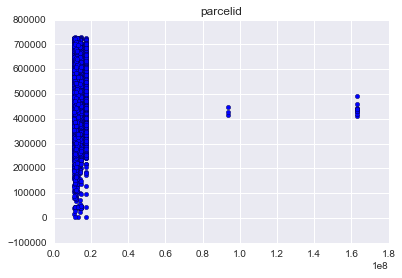

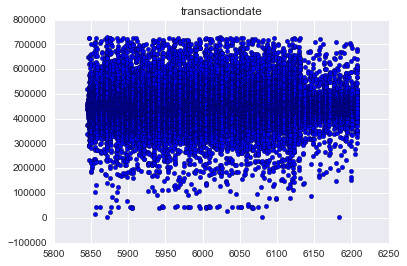

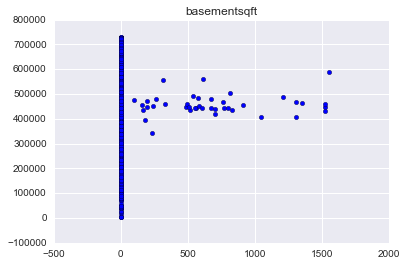

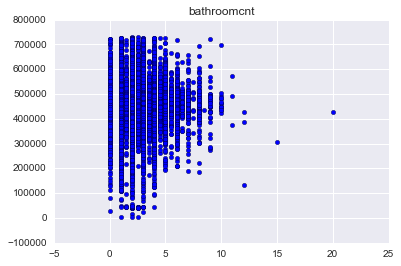

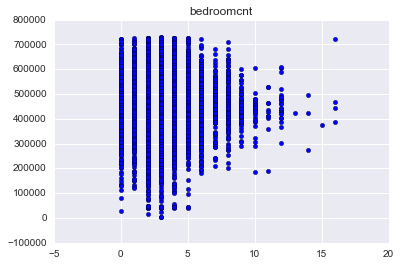

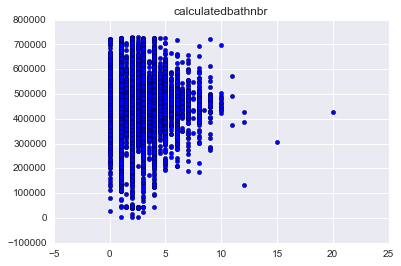

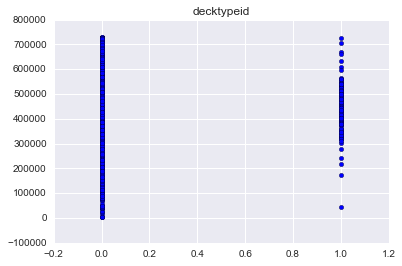

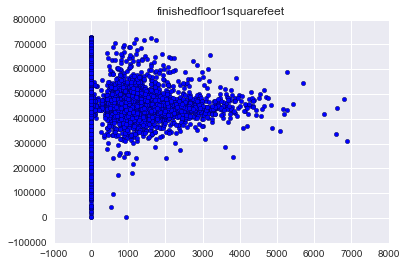

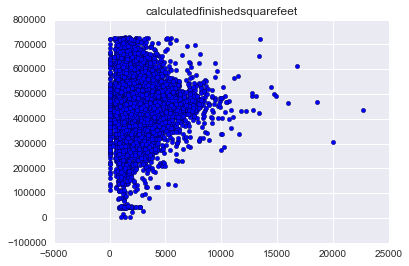

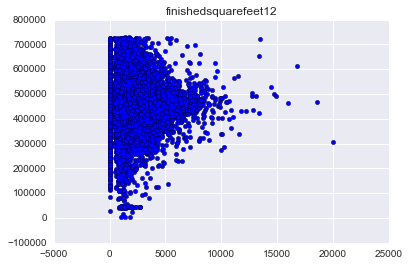

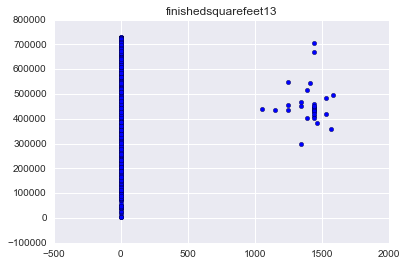

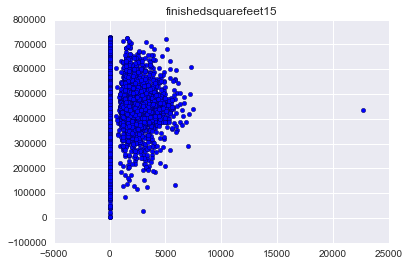

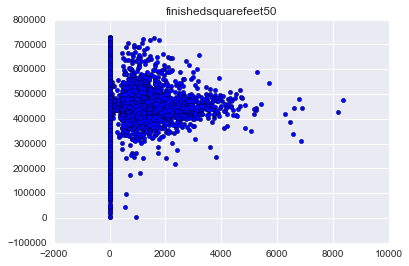

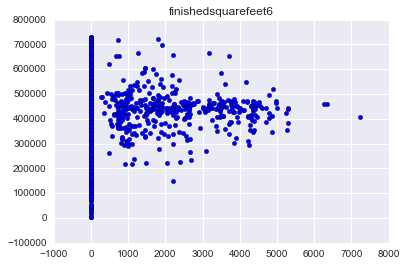

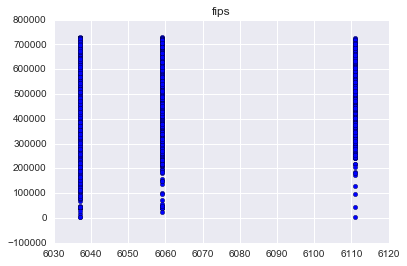

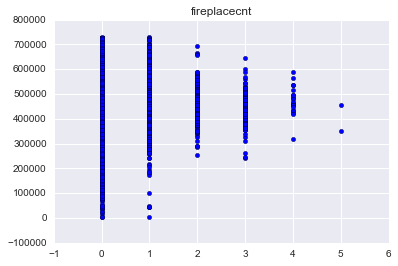

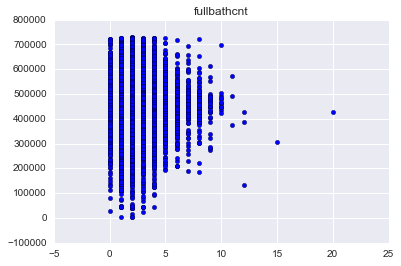

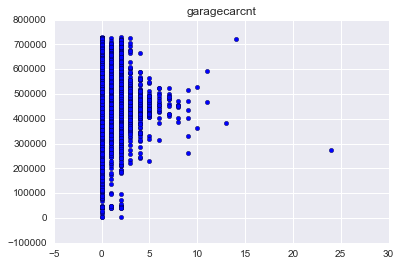

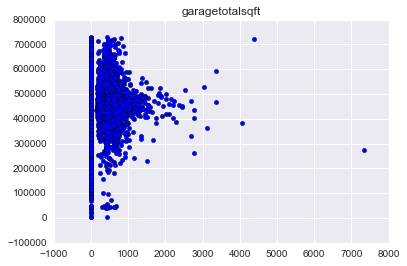

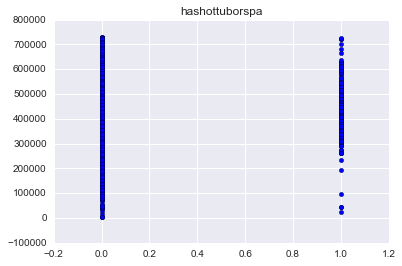

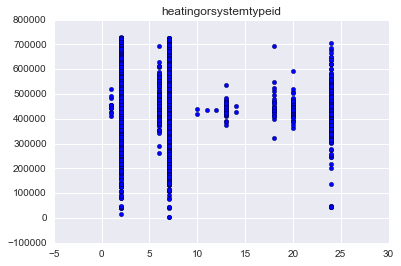

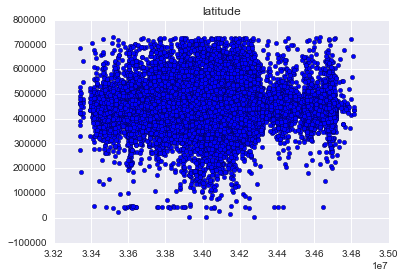

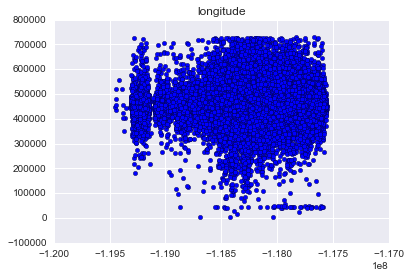

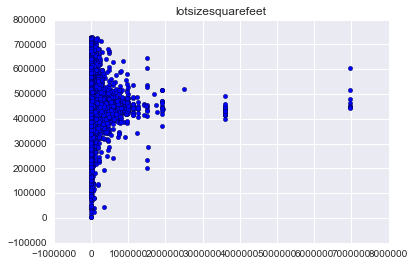

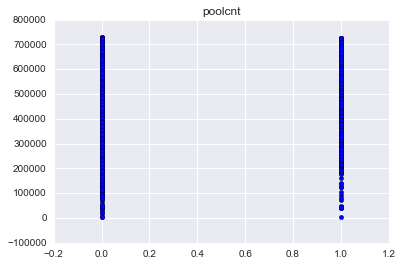

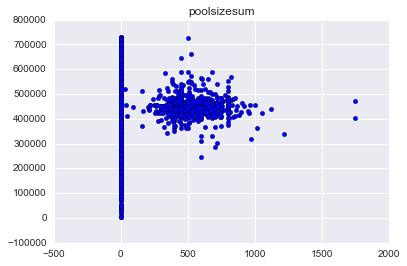

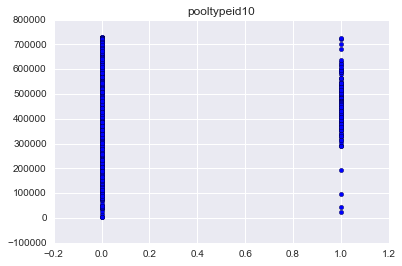

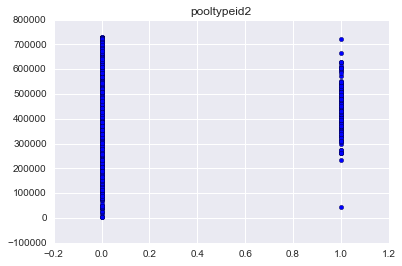

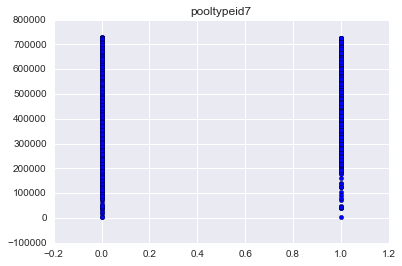

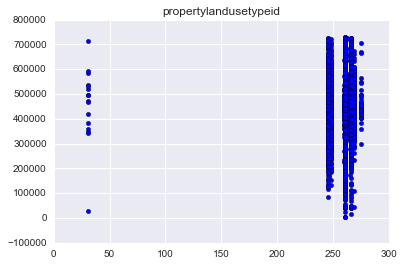

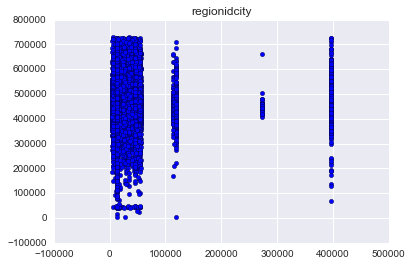

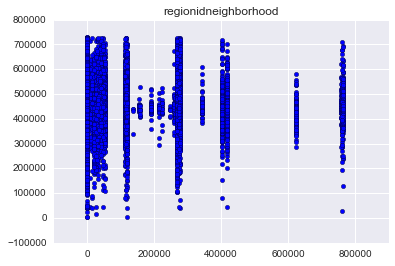

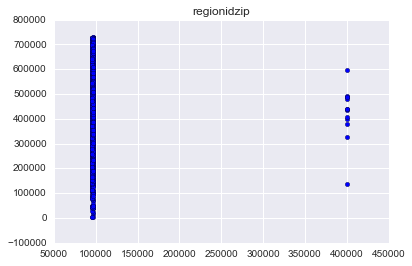

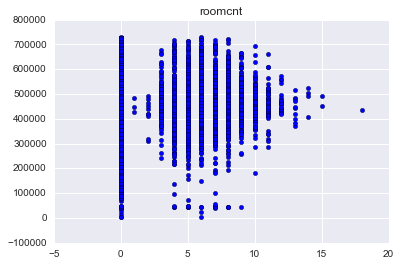

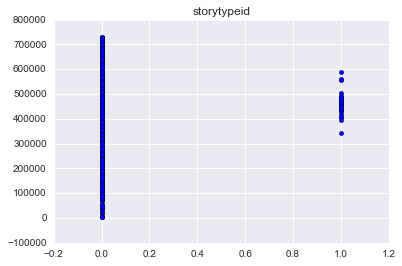

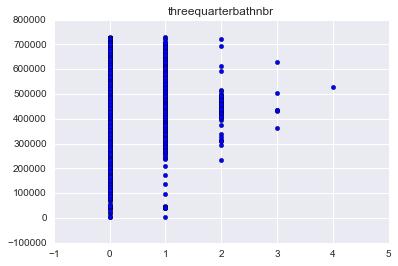

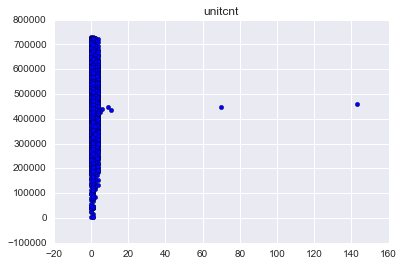

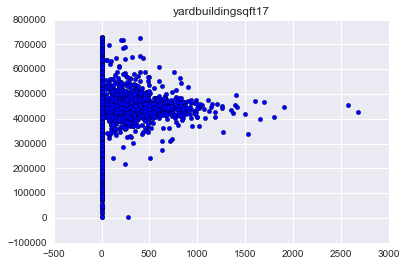

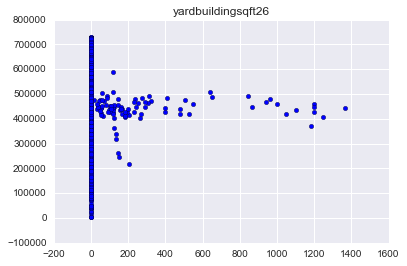

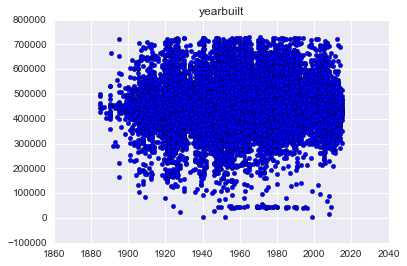

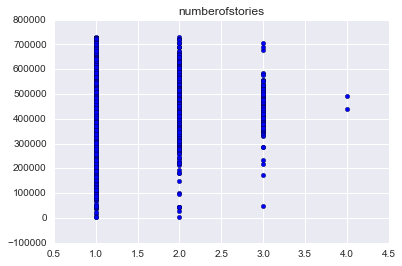

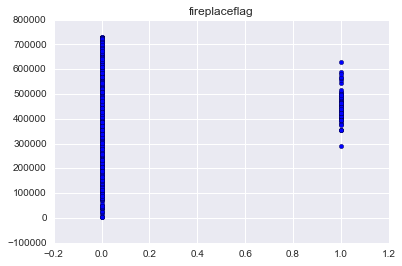

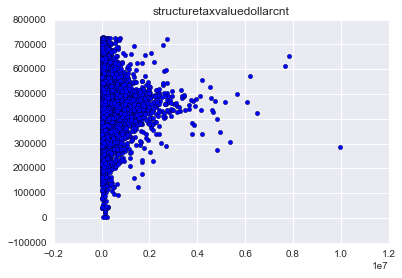

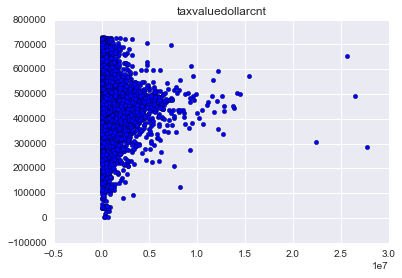

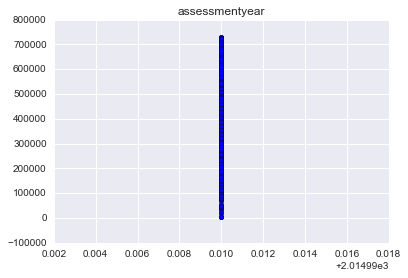

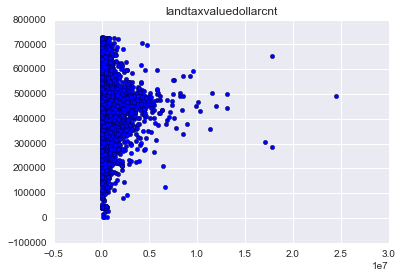

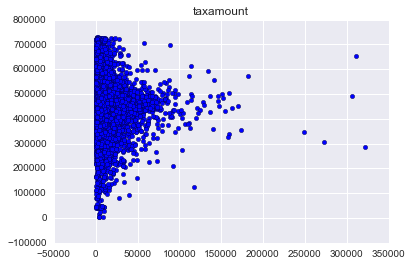

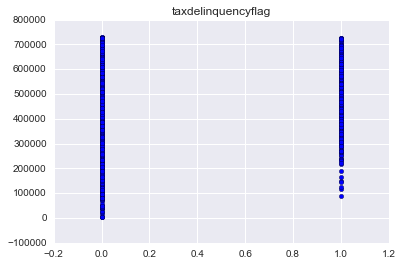

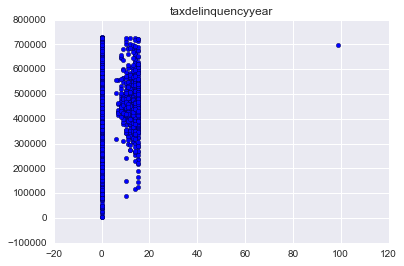

In [ ]:
%matplotlib inline
for i in train.columns:
    plt.scatter(train.loc[train['target']<0.5,i],np.exp((train.loc[train['target']<0.5,'target']+13)))
    plt.title(i)
    plt.show()